In [35]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os

from scipy.linalg import sqrtm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

sys.path.append(os.path.abspath(".."))

from src.qst.models.QST_transfer import (
    QSTTransferModel, QSTConfig, n_alpha_from_dim, fidelity
)

from src.qst.models.mle import MLEQST

from scipy.linalg import sqrtm
def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2

def batch_predict_fidelity(model: QSTTransferModel, X: np.ndarray, Y_rho: np.ndarray, batch_size: int = 256):
    """Predict alphas -> rhos and compute mean/std fidelity."""
    alphas = model.predict_alpha(X, batch_size=batch_size)
    rhos   = model.predict_rho(alphas)
    F = np.array([fidelity(rhos[i], Y_rho[i]) for i in range(len(Y_rho))], dtype=np.float64)
    return F.mean(), F.std(), F
tf.get_logger().setLevel(logging.ERROR)

# Loading Dataset

In [3]:
data_gen = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.01_transfer.npz', allow_pickle=True)

X_gen = data_gen['counts']
y_gen= data_gen['states']

data_ghz = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.01_ghz.npz', allow_pickle=True)
X_ghz = data_ghz['counts']
y_ghz = data_ghz['states']

rng = np.random.default_rng(42)
test_ind_pure = rng.choice(50_000, size=100, replace=False)
test_ind_mixed = rng.integers(50_000, 100_000, size=100)

d = y_gen.shape[1] 
n_features = X_gen.shape[1]
print(d, n_features, X_gen.shape, y_gen.shape, X_ghz.shape, y_ghz.shape)

8 216 (100000, 216) (100000, 8, 8) (3000, 216) (3000, 8, 8)


In [4]:
# Build train set by excluding the provided test indices
test_idx = np.concatenate([test_ind_pure, test_ind_mixed])
mask = np.ones(len(X_gen), dtype=bool)
mask[test_idx] = False

X_train_gen, Y_train_gen = X_gen[mask], y_gen[mask]
X_test_gen,  Y_test_gen  = X_gen[test_idx], y_gen[test_idx]

print("General train:", X_train_gen.shape, Y_train_gen.shape)
print("General test :", X_test_gen.shape,  Y_test_gen.shape)



General train: (99801, 216) (99801, 8, 8)
General test : (200, 216) (200, 8, 8)


In [16]:
cfg = QSTConfig(
    hidden_sizes=(512, 512, 512),
    dropout=0.2,
    use_batchnorm=True,
    lr_backbone=1e-3,
    lr_head=1e-3,
    batch_size=128,
    epochs=20,
    val_split=0.1,
    early_stopping_patience=10,
    early_stopping_min_delta=0.0,
)

model = QSTTransferModel(
    input_dim=n_features,
    n_alpha=n_alpha_from_dim(d),   # equals d**2
    d=d,
    lam=0.8,
    config=cfg,
)

# adapt the input normalizer on the SOURCE distribution
model.adapt_normalizer(X_train_gen)

# Pretrain on general dataset
hist = model.pretrain_general(X_train_gen, Y_train_gen, verbose=1)

# Evaluate on your held-out general test set (pure+mixed)
meanF, stdF, F_all = batch_predict_fidelity(model, X_test_gen, Y_test_gen)
print(f"[General -> General/Test] mean fidelity = {meanF:.6f} ± {stdF:.6f}")

model.save_weights("pretrained_transfer_model.weights.h5")


Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - fidelity_metric: 0.7138 - loss: 0.3719 - val_fidelity_metric: 0.9623 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - fidelity_metric: 0.9359 - loss: 0.0255 - val_fidelity_metric: 0.9693 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - fidelity_metric: 0.9694 - loss: 0.0101 - val_fidelity_metric: 0.9704 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - fidelity_metric: 0.9761 - loss: 0.0080 - val_fidelity_metric: 0.9723 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - fidelity_metric: 0.9782 - loss: 0.0073 - val_fidelity_metric: 0.9743 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - fidelity_metric: 0.9796 - loss: 0.0069 - val_fidelity_metric: 0.9790 - val_loss: 0.0074 - learning_rate: 0.00

In [23]:
len(X_ghz)

3000

In [24]:


train_idx = rng.choice(len(X_ghz), size=2000, replace=False)

X_train_ghz, Y_train_ghz = X_ghz[train_idx], y_ghz[train_idx]
X_test_ghz,  Y_test_ghz  = np.delete(X_ghz, train_idx, axis=0), np.delete(y_ghz, train_idx, axis=0)

In [25]:
transfer_hist = model.transfer_to_target(
    X_tgt=X_train_ghz,
    Y_tgt_rho=Y_train_ghz,
    last_k_to_unfreeze=1,
    lambda_l2sp=0.0,
    head_only_epochs=30,
    finetune_epochs=20,
    verbose=1,
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - fidelity_metric: 0.9996 - loss: 1.7185e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.7159e-05 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fidelity_metric: 0.9996 - loss: 1.6955e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.6064e-05 - learning_rate: 0.0010
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fidelity_metric: 0.9996 - loss: 1.6993e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.4146e-05 - learning_rate: 0.0010
Epoch 4/30
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fidelity_metric: 0.9996 - loss: 1.6043e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fidelity_metric: 0.9996 - loss: 1.6104e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.9710e-05 - learning_rate: 0.0010
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fidelity_metric: 0.9996 - loss: 1.5851e-04 - val_fidelity_metric: 0.9999 - val_loss: 3.2639e-05 - l

In [26]:
#compare the results of transfer learning vs general model on GHZ eval set
#load the general model weights for comparison and name it something other than model
model_general = QSTTransferModel(
    input_dim=n_features,
    n_alpha=n_alpha_from_dim(d), 
    d=d,
    lam=0.8,
    config=cfg,
)

model_general.load_weights("pretrained_transfer_model.weights.h5")


meanF_ghz, stdF_ghz, F_all_ghz = batch_predict_fidelity(model, X_test_ghz, Y_test_ghz)
meanF_ghz_general , stdF_ghz_general , F_all_ghz_general  = batch_predict_fidelity(model_general, X_test_ghz, Y_test_ghz)
print(f"[GHZ/Transfer] mean fidelity = {meanF_ghz:.6f} ± {stdF_ghz:.6f}")
print(f"[GHZ/General] mean fidelity = {meanF_ghz_general:.6f} ± {stdF_ghz_general:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[GHZ/Transfer] mean fidelity = 0.999378 ± 0.001469
[GHZ/General] mean fidelity = 0.874228 ± 0.074693


In [ ]:
data_ghz_20 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.2_ghz.npz', allow_pickle=True)
X_ghz_20 = data_ghz_20['counts']
y_ghz_20 = data_ghz_20['states']

#select random 100 states for testing
train_ind_ghz = rng.choice(2000, size=1900, replace=False)

transfer_hist = model.transfer_to_target(
    X_tgt=X_ghz_20[train_ind_ghz],
    Y_tgt_rho=y_ghz_20[train_ind_ghz],
    last_k_to_unfreeze=1,
    lambda_l2sp=0.0,
    head_only_epochs=30,
    finetune_epochs=20,
    verbose=1,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - fidelity_metric: 0.9988 - loss: 4.3950e-04 - val_fidelity_metric: 0.9999 - val_loss: 5.3950e-05 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fidelity_metric: 0.9995 - loss: 1.9384e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.7619e-05 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fidelity_metric: 0.9995 - loss: 1.8184e-04 - val_fidelity_metric: 0.9999 - val_loss: 5.0150e-05 - learning_rate: 0.0010
Epoch 4/30
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fidelity_metric: 0.9995 - loss: 1.8389e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fidelity_metric: 0.9995 - loss: 1.8354e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.5719e-05 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fidelity_metric: 0.9995 - loss: 1.8263e-04 - val_fidelity_metric: 0.9999 - val_loss: 4.8954e-05 - l

In [ ]:
X_test_ghz_20 = np.delete(X_ghz_20, train_ind_ghz, axis=0)
Y_test_ghz_20 = np.delete(y_ghz_20, train_ind_ghz, axis=0)

meanF_ghz_20, stdF_ghz_20, F_all_ghz_20 = batch_predict_fidelity(model, X_test_ghz_20, Y_test_ghz_20)
meanF_ghz_general_20, stdF_ghz_general_20, F_all_ghz_general_20 = batch_predict_fidelity(model_general, X_test_ghz_20, Y_test_ghz_20)
print(f"[GHZ/Transfer] mean fidelity = {meanF_ghz_20:.6f} ± {stdF_ghz_20:.6f}")
print(f"[GHZ/General] mean fidelity = {meanF_ghz_general_20:.6f} ± {stdF_ghz_general_20:.6f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[GHZ/Transfer] mean fidelity = 0.999416 ± 0.001758
[GHZ/General] mean fidelity = 0.823393 ± 0.047362


# Plotting to Show the performance

In [39]:
def make_base_model(d, n_feats):
    return QSTTransferModel(
    input_dim=n_feats,
    n_alpha=n_alpha_from_dim(d), 
    d=d,
    lam=0.8,
    config=cfg,
    )

def fidelity_transfer_model(X, y, train_indices, head_only_epochs=30, finetune_epochs=20):
    
    m = make_base_model(y.shape[1], X.shape[1])
    m.load_weights("pretrained_transfer_model.weights.h5")

    transfer_hist = m.transfer_to_target(
        X_tgt=X[train_indices],
        Y_tgt_rho=y[train_indices],
        last_k_to_unfreeze=1,
        lambda_l2sp=0.0,
        head_only_epochs=head_only_epochs,
        finetune_epochs=finetune_epochs,
        verbose=0,
    )
    X_test = np.delete(X, train_indices, axis=0)
    Y_test = np.delete(y, train_indices, axis=0)

    meanF, stdF, F_all = batch_predict_fidelity(m, X_test, Y_test)
    return meanF, stdF

def fidelity_general_model(X, y, train_indices):
    
    m = make_base_model(y.shape[1], X.shape[1])
    m.load_weights("pretrained_transfer_model.weights.h5")
    
    X_test = np.delete(X, train_indices, axis=0)
    Y_test = np.delete(y, train_indices, axis=0)

    meanF, stdF, F_all = batch_predict_fidelity(m, X_test, Y_test)
    return meanF, stdF





In [28]:
# load the data
data_ghz_01 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.01_ghz.npz', allow_pickle=True)
data_ghz_02 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.02_ghz.npz', allow_pickle=True)
data_ghz_03 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.03_ghz.npz', allow_pickle=True)
data_ghz_05 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.05_ghz.npz', allow_pickle=True)
data_ghz_10 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.10_ghz.npz', allow_pickle=True)
data_ghz_15 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.15_ghz.npz', allow_pickle=True)
data_ghz_20 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.20_ghz.npz', allow_pickle=True)

X_ghz_01 = data_ghz_01['counts']; Y_ghz_01 = data_ghz_01['states']
X_ghz_02 = data_ghz_02['counts']; Y_ghz_02 = data_ghz_02['states']
X_ghz_03 = data_ghz_03['counts']; Y_ghz_03 = data_ghz_03['states']
X_ghz_05 = data_ghz_05['counts']; Y_ghz_05 = data_ghz_05['states']
X_ghz_10 = data_ghz_10['counts']; Y_ghz_10 = data_ghz_10['states']
X_ghz_15 = data_ghz_15['counts']; Y_ghz_15 = data_ghz_15['states']
X_ghz_20 = data_ghz_20['counts']; Y_ghz_20 = data_ghz_20['states']

train_ind_ghz = rng.choice(3000, size=2000, replace=False)


In [31]:
fid_T_01 , std_T_01 =  fidelity_transfer_model(X_ghz_01, Y_ghz_01, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_02 , std_T_02 =  fidelity_transfer_model(X_ghz_02, Y_ghz_02, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_03 , std_T_03 =  fidelity_transfer_model(X_ghz_03, Y_ghz_03, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_05 , std_T_05 =  fidelity_transfer_model(X_ghz_05, Y_ghz_05, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_10 , std_T_10 =  fidelity_transfer_model(X_ghz_10, Y_ghz_10, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_15 , std_T_15 =  fidelity_transfer_model(X_ghz_15, Y_ghz_15, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)
fid_T_20 , std_T_20 =  fidelity_transfer_model(X_ghz_20, Y_ghz_20, train_ind_ghz, head_only_epochs=30, finetune_epochs=30)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [37]:
# mle results
mle = MLEQST(n_qubits=3)
MLE_fid_01, MLE_std_01, _ = mle.avg_fidelity(np.delete(X_ghz_01, train_ind_ghz, axis=0), np.delete(Y_ghz_01, train_ind_ghz, axis=0))
MLE_fid_02, MLE_std_02, _ = mle.avg_fidelity(np.delete(X_ghz_02, train_ind_ghz, axis=0), np.delete(Y_ghz_02, train_ind_ghz, axis=0))
MLE_fid_03, MLE_std_03, _ = mle.avg_fidelity(np.delete(X_ghz_03, train_ind_ghz, axis=0), np.delete(Y_ghz_03, train_ind_ghz, axis=0))
MLE_fid_05, MLE_std_05, _ = mle.avg_fidelity(np.delete(X_ghz_05, train_ind_ghz, axis=0), np.delete(Y_ghz_05, train_ind_ghz, axis=0))
MLE_fid_10, MLE_std_10, _ = mle.avg_fidelity(np.delete(X_ghz_10, train_ind_ghz, axis=0), np.delete(Y_ghz_10, train_ind_ghz, axis=0))
MLE_fid_15, MLE_std_15, _ = mle.avg_fidelity(np.delete(X_ghz_15, train_ind_ghz, axis=0), np.delete(Y_ghz_15, train_ind_ghz, axis=0))
MLE_fid_20, MLE_std_20, _ = mle.avg_fidelity(np.delete(X_ghz_20, train_ind_ghz, axis=0), np.delete(Y_ghz_20, train_ind_ghz, axis=0))


In [40]:
fid_G_01 , std_G_01 =  fidelity_general_model(X_ghz_01, Y_ghz_01, train_ind_ghz)
fid_G_02 , std_G_02 =  fidelity_general_model(X_ghz_02, Y_ghz_02, train_ind_ghz)
fid_G_03 , std_G_03 =  fidelity_general_model(X_ghz_03, Y_ghz_03, train_ind_ghz)
fid_G_05 , std_G_05 =  fidelity_general_model(X_ghz_05, Y_ghz_05, train_ind_ghz)
fid_G_10 , std_G_10 =  fidelity_general_model(X_ghz_10, Y_ghz_10, train_ind_ghz)
fid_G_15 , std_G_15 =  fidelity_general_model(X_ghz_15, Y_ghz_15, train_ind_ghz)
fid_G_20 , std_G_20 =  fidelity_general_model(X_ghz_20, Y_ghz_20, train_ind_ghz)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


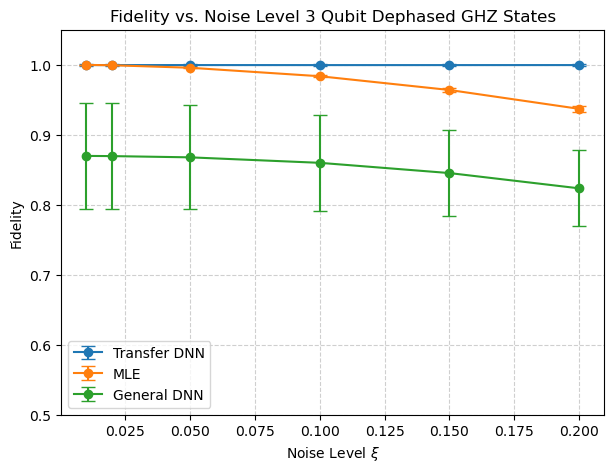

In [42]:
xi = [0.01, 0.02, 0.05, 0.1, 0.15, 0.20]
#MLE fidelities
fidelities_MLE = np.array([MLE_fid_01, MLE_fid_02, MLE_fid_05, MLE_fid_10, MLE_fid_15, MLE_fid_20])
std_MLE = np.array([MLE_std_01, MLE_std_02, MLE_std_05, MLE_std_10, MLE_std_15, MLE_std_20])

#NN Transfer fidelities
fidelities_NN = np.array([fid_T_01, fid_T_02, fid_T_05, fid_T_10, fid_T_15, fid_T_20])
std_NN =  np.array([std_T_01, std_T_02, std_T_05, std_T_10, std_T_15, std_T_20])

# NN general fidelities
fidelities_NN_G = np.array([fid_G_01, fid_G_02, fid_G_05, fid_G_10, fid_G_15, fid_G_20])
std_NN_G = np.array([std_G_01, std_G_02, std_G_05, std_G_10, std_G_15, std_G_20])

plt.figure(figsize=(7,5))
plt.errorbar(xi, fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="Transfer DNN", markersize=6)
plt.errorbar(xi, fidelities_MLE, yerr=std_MLE, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(xi, fidelities_NN_G, yerr=std_NN_G, fmt='o-', capsize=5, label="General DNN", markersize=6)
plt.xlabel(r"Noise Level $\xi$")
plt.ylabel("Fidelity")
plt.title("Fidelity vs. Noise Level 3 Qubit Dephased GHZ States")
plt.ylim(0.5,1.05)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()